In [5]:
%pip install memory-profiler
%pip install timeout-decorator
%pip install networkx

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [6]:
import pandas as pd
import numpy as np
from math import ceil
import networkx as nx
from timeout_decorator import timeout
from queue import PriorityQueue
from itertools import combinations
import matplotlib.pyplot as plt
import time
import tracemalloc
import os
import ast
import psutil
import time
import threading
import subprocess


In [7]:
#Determinando tempo máximo de 30min
MAX_TIME_SEG = 1800

### Auxiliares

#### Criação do dataset com base no nome dos arquivos, e posterior ordenação de acordo com nós

In [8]:
def read_and_order_ds(file_path, sort_column="Nós"):
    """
    Lê um arquivo de dataset delimitado por tabulação e o ordena com base em uma coluna específica.
    
    Parâmetros:
    - file_path (str): Caminho para o arquivo a ser lido.
    - sort_column (str): Nome da coluna pela qual o dataset será ordenado. Padrão: 'Nós'.
    
    Retorna:
    - dados_limiares (DataFrame): DataFrame ordenado.
    """
    try:
        dados_limiares = pd.read_csv(file_path, delimiter='\t')
        
        if sort_column not in dados_limiares.columns:
            raise KeyError(f"A coluna '{sort_column}' não foi encontrada no arquivo.")
        
        dados_limiares = dados_limiares.sort_values(by=sort_column)
        
        print(dados_limiares)
        return dados_limiares

    except FileNotFoundError:
        print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
    
    except pd.errors.EmptyDataError:
        print(f"Erro: O arquivo '{file_path}' está vazio ou não contém dados.")
    
    except KeyError as e:
        print(f"Key Error: {e}")
    
    except Exception as e:
        print(f"Erro inesperado: {e}")


dados_limiares = read_and_order_ds("limiares.txt")

     Dataset    Nós               Limiar
0        a15     15                   50
1      eil51     51                  426
2   berlin52     52                 7542
3       st70     70                  675
4      eil76     76                  538
..       ...    ...                  ...
74   rl11849  11849      [920847,923368]
75  usa13509  13509  [19947008,19982889]
76  brd14051  14051      [468942,469445]
77    d15112  15112    [1564590,1573152]
78    d18512  18512      [644650,645488]

[79 rows x 3 columns]


#### Função para calcular a distância euclidiana

In [9]:
def distancia_euclidiana(pontos):
    """
    Calcula a distância euclidiana entre todos os pares de pontos fornecidos.
    
    Parâmetros:
    - pontos (list ou np.ndarray): Lista ou array numpy contendo as coordenadas dos pontos.
    
    Retorna:
    - arestas_euclidiana (list): Lista de tuplas contendo os pares de pontos e suas respectivas distâncias.
    """
    try:
        # Verifica se pontos é uma lista ou um array numpy
        if not isinstance(pontos, (list, np.ndarray)):
            raise TypeError("O parâmetro 'pontos' deve ser uma lista ou um array numpy.")
        
        # Verifica se há pelo menos dois pontos
        if len(pontos) < 2:
            raise ValueError("É necessário pelo menos dois pontos para calcular a distância.")
        
        # Verifica se cada ponto tem a mesma dimensão
        dim_ponto = len(pontos[0])
        if not all(len(p) == dim_ponto for p in pontos):
            raise ValueError("Todos os pontos devem ter a mesma dimensão.")
        
        np.array(pontos)  # Converte para array numpy, se necessário
        arestas_euclidiana = []
        tamanho_pontos = len(pontos)

        for i in range(tamanho_pontos):
            for j in range(i + 1, tamanho_pontos):
                # Distância Euclidiana
                ponto_i = np.array(pontos[i])
                ponto_j = np.array(pontos[j])
                distancia = np.linalg.norm(ponto_i - ponto_j)
                arestas_euclidiana.append((i, j, distancia))

        return arestas_euclidiana

    except TypeError as e:
        print(f"Erro de tipo: {e}")
    except ValueError as e:
        print(f"Erro de valor: {e}")
    except Exception as e:
        print(f"Erro inesperado: {e}")


Teste:

In [10]:
# Teste 1: Pontos 2D simples (caso básico)
pontos = np.array([[0, 0], [1, 1], [2, 2], [3, 3]])
arestas_euclidiana = distancia_euclidiana(pontos)
print("Teste 1: Pontos 2D simples")
for aresta in arestas_euclidiana:
    print(f'Pontos {aresta[0]} e {aresta[1]}: Distância Euclidiana = {aresta[2]}')
print()

# Teste 2: Pontos 3D
pontos = np.array([[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3]])
arestas_euclidiana = distancia_euclidiana(pontos)
print("Teste 2: Pontos 3D")
for aresta in arestas_euclidiana:
    print(f'Pontos {aresta[0]} e {aresta[1]}: Distância Euclidiana = {aresta[2]}')
print()

# Teste 3: Apenas dois pontos
pontos = np.array([[0, 0], [3, 4]])
arestas_euclidiana = distancia_euclidiana(pontos)
print("Teste 3: Apenas dois pontos")
for aresta in arestas_euclidiana:
    print(f'Pontos {aresta[0]} e {aresta[1]}: Distância Euclidiana = {aresta[2]}')
print()

# Teste 4: Pontos com valores negativos
pontos = np.array([[-1, -1], [0, 0], [1, 1]])
arestas_euclidiana = distancia_euclidiana(pontos)
print("Teste 4: Pontos com valores negativos")
for aresta in arestas_euclidiana:
    print(f'Pontos {aresta[0]} e {aresta[1]}: Distância Euclidiana = {aresta[2]}')
print()

# Teste 5: Entrada inválida - Menos de dois pontos
try:
    pontos = np.array([[0, 0]])
    arestas_euclidiana = distancia_euclidiana(pontos)
except Exception as e:
    print(f"Teste 5: Menos de dois pontos - Erro: {e}")
print()

# Teste 6: Entrada inválida - Dimensões diferentes entre pontos
try:
    pontos = np.array([[0, 0], [1, 1, 1]])
    arestas_euclidiana = distancia_euclidiana(pontos)
except Exception as e:
    print(f"Teste 6: Pontos com dimensões diferentes - Erro: {e}")
print()

# Teste 7: Pontos vazios
try:
    pontos = np.array([])
    arestas_euclidiana = distancia_euclidiana(pontos)
except Exception as e:
    print(f"Teste 7: Pontos vazios - Erro: {e}")
print()

# Teste 8: Pontos com valores decimais
pontos = np.array([[0.5, 1.5], [2.3, 3.7], [4.1, 5.9]])
arestas_euclidiana = distancia_euclidiana(pontos)
print("Teste 8: Pontos com valores decimais")
for aresta in arestas_euclidiana:
    print(f'Pontos {aresta[0]} e {aresta[1]}: Distância Euclidiana = {aresta[2]}')
print()


Teste 1: Pontos 2D simples
Pontos 0 e 1: Distância Euclidiana = 1.4142135623730951
Pontos 0 e 2: Distância Euclidiana = 2.8284271247461903
Pontos 0 e 3: Distância Euclidiana = 4.242640687119285
Pontos 1 e 2: Distância Euclidiana = 1.4142135623730951
Pontos 1 e 3: Distância Euclidiana = 2.8284271247461903
Pontos 2 e 3: Distância Euclidiana = 1.4142135623730951

Teste 2: Pontos 3D
Pontos 0 e 1: Distância Euclidiana = 1.7320508075688772
Pontos 0 e 2: Distância Euclidiana = 3.4641016151377544
Pontos 0 e 3: Distância Euclidiana = 5.196152422706632
Pontos 1 e 2: Distância Euclidiana = 1.7320508075688772
Pontos 1 e 3: Distância Euclidiana = 3.4641016151377544
Pontos 2 e 3: Distância Euclidiana = 1.7320508075688772

Teste 3: Apenas dois pontos
Pontos 0 e 1: Distância Euclidiana = 5.0

Teste 4: Pontos com valores negativos
Pontos 0 e 1: Distância Euclidiana = 1.4142135623730951
Pontos 0 e 2: Distância Euclidiana = 2.8284271247461903
Pontos 1 e 2: Distância Euclidiana = 1.4142135623730951

Erro 

#### Criação da extração dos dados do dataset.

In [11]:
def dataset_info(idx_dataset, dataset_limiar):
    """
    Extrai informações do dataset, como coordenadas, número de nós, e limiar.
    
    Parâmetros:
    - idx_dataset (int): Índice do dataset no DataFrame.
    - dataset_limiar (pd.DataFrame): DataFrame contendo informações dos datasets.

    Retorna:
    - cordenadas (list): Lista de coordenadas dos nós.
    - numero_de_nos (int): Número de nós no grafo.
    - limiar (int ou float): Valor do limiar.
    - name_dataset (str): Nome do dataset.

    Lança:
    - ValueError: Para problemas na leitura ou inconsistências no arquivo.
    - KeyError: Para colunas ausentes no DataFrame.
    - FileNotFoundError: Se o arquivo .tsp não for encontrado.
    """
    try:
        # Valida se as colunas necessárias estão presentes no DataFrame
        for coluna in ['Dataset', 'Nós', 'Limiar']:
            if coluna not in dataset_limiar.columns:
                raise KeyError(f"A coluna '{coluna}' não foi encontrada no DataFrame.")

        # Verifica se o índice está dentro dos limites do DataFrame
        if not (0 <= idx_dataset < len(dataset_limiar)):
            raise IndexError(f"O índice {idx_dataset} está fora dos limites do DataFrame.")

        # Obtém o nome do dataset e o caminho do arquivo .tsp
        name_dataset = dataset_limiar.loc[idx_dataset, 'Dataset']
        tsp_file_path = f"datasets/{name_dataset}.tsp"

        # Tenta abrir o arquivo .tsp
        try:
            with open(tsp_file_path, 'r') as file:
                lines = file.readlines()
        except FileNotFoundError:
            raise FileNotFoundError(f"O arquivo '{tsp_file_path}' não foi encontrado.")

        # Verifica se a seção NODE_COORD_SECTION existe no arquivo
        try:
            coord_section_index = lines.index('NODE_COORD_SECTION\n')
        except ValueError:
            raise ValueError(f"A seção 'NODE_COORD_SECTION' não foi encontrada no arquivo '{tsp_file_path}'.")

        # Criando um grafo direcionado
        G = nx.Graph()

        # Adicionando nós e coordenadas ao grafo
        for line in lines[coord_section_index + 1:]:
            # Ignorar a linha EOF
            if line.strip().lower() == 'eof':
                break

            node_info = line.split()

            # Valida se a linha contém pelo menos 3 elementos
            if len(node_info) < 3:
                raise ValueError(f"Dados inválidos no arquivo '{tsp_file_path}': {line.strip()}")

            # Converte os dados para o formato esperado
            node_id = int(node_info[0])
            x_coord = float(node_info[1])
            y_coord = float(node_info[2])
            G.add_node(node_id, pos=(x_coord, y_coord))

        # Extrair apenas as coordenadas
        cordenadas = [pos for _, pos in G.nodes(data='pos')]

        # Obtém o número de nós e verifica se é válido
        numero_de_nos = int(dados_limiares.loc[idx_dataset, 'Nós'])
        if numero_de_nos <= 0:
            raise ValueError(f"O número de nós '{numero_de_nos}' deve ser maior que zero.")

        # Processa o limiar
        limiar_raw = dados_limiares.loc[idx_dataset, 'Limiar']
        if '[' in str(limiar_raw):
            try:
                # Avalia a string como uma lista
                lista_valores = ast.literal_eval(limiar_raw)
                if not isinstance(lista_valores, list) or not lista_valores:
                    raise ValueError(f"O limiar '{limiar_raw}' não é uma lista válida.")
                limiar = lista_valores[0]
            except Exception:
                raise ValueError(f"O limiar '{limiar_raw}' não pôde ser avaliado como uma lista.")
        else:
            try:
                # Converte diretamente para inteiro ou float
                limiar = int(limiar_raw)
            except ValueError:
                limiar = float(limiar_raw)

        return cordenadas, numero_de_nos, limiar, name_dataset

    except KeyError as e:
        print(f"Erro de chave: {e}")
    except FileNotFoundError as e:
        print(f"Erro de arquivo: {e}")
    except IndexError as e:
        print(f"Erro de índice: {e}")
    except ValueError as e:
        print(f"Erro de valor: {e}")
    except Exception as e:
        print(f"Erro inesperado: {e}")


Teste:

In [12]:
idx_dataset = 0
cordenadas, numero_de_nos, limiar,  name_dataset = dataset_info(idx_dataset, dados_limiares)
print(f"""
Informações do Dataset:
------------------------
- Nome do Dataset: {name_dataset}
- Número de Nós  : {numero_de_nos}
- Limiar         : {limiar}

Coordenadas dos Nós:
{cordenadas}
""")



Informações do Dataset:
------------------------
- Nome do Dataset: a15
- Número de Nós  : 15
- Limiar         : 50

Coordenadas dos Nós:
[(288.0, 149.0), (288.0, 129.0), (270.0, 133.0), (256.0, 141.0), (256.0, 157.0), (246.0, 157.0), (236.0, 169.0), (228.0, 169.0), (228.0, 161.0), (220.0, 169.0), (212.0, 169.0), (204.0, 169.0)]



### Problema: Caixeiro Viajante (TSP - Travelling Salesman Problem)

#### Algortimo: Branch and bound (Solução ótima)

In [13]:
class Node:
    """
    Representa um nó na árvore do algoritmo Branch and Bound.
    """

    def __init__(self, bound, nivel, custo, solucao):
        """
        Inicializa um nó com os seguintes atributos:
        
        Parâmetros:
        - bound (float): Limite associado ao nó na árvore.
        - nivel (int): Nível do nó na árvore.
        - custo (float): Custo acumulado até o nó atual.
        - solucao (list): Solução parcial associada ao nó.
        """
        self.bound = bound
        self.nivel = nivel
        self.custo = custo
        self.solucao = solucao

    def __lt__(self, other_node):
        """
        Utilizado para determinar a ordem de prioridade em uma fila de prioridade.
        Nós com menor bound têm maior prioridade.

        Parâmetros:
        - other_node (Node): Outro nó a ser comparado.
        
        Retorna:
        - bool: True se o bound do nó atual for menor que o bound do outro nó.
        """
        return self.bound < other_node.bound


In [14]:
def bound(G, nodes):
    """
    Calcula um limite inferior para a solução do problema TSP (Travelling Salesman Problem).
    
    Este limite é baseado na soma das arestas visitadas e nas menores arestas incidentes
    necessárias para completar o caminho no grafo.

    Parâmetros:
    - G (networkx.Graph): Grafo representando o problema TSP.
    - nodes (list): Lista de nós visitados na solução parcial.

    Retorna:
    - int: Um valor estimado para o custo total da solução, arredondado para cima.
    """

    # Inicializa a estimativa total
    estimativa = 0

    # Converte a lista de vértices visitados em uma lista de arestas
    size_nodes = len(nodes)
    edges = [(nodes[i], nodes[i+1]) for i in range(size_nodes - 1)]

    # Calcula o custo total das arestas na solução parcial (considerando o dobro do peso de cada aresta)
    for (u, v) in edges:
        estimativa += (2 * G[u][v]['weight'])

    # Itera sobre todos os vértices do grafo para considerar arestas não visitadas
    for u in G.nodes():
        # Filtra as arestas que já foram usadas na solução parcial
        arestas_u = list(filter(lambda x: x[0] == u or x[1] == u, edges))

        # Verifica se o vértice 'u' tem menos de duas arestas incidentes na solução parcial
        size_arestas_u = len(arestas_u)
        if size_arestas_u < 2:
            # Obtém as arestas incidentes ao vértice 'u' e ordena pelo peso
            dados_u = list(G.edges(u, data=True))
            dados_u = sorted(dados_u, key=lambda x: x[2]['weight'])
            w1, w2 = dados_u[0][2]['weight'], dados_u[1][2]['weight']

            # Caso 'u' não tenha arestas incidentes, adiciona os dois menores pesos
            if size_arestas_u == 0:
                estimativa += w1 + w2

            # Caso 'u' tenha uma única aresta incidente, adiciona o menor peso restante
            elif size_arestas_u == 1:
                u, v = arestas_u[0]
                peso_necessario = G[u][v]['weight']
                estimativa += w1 if w1 < peso_necessario else w2

    # Divide a estimativa por 2 e arredonda para cima (TSP considera ida e volta)
    output = ceil(estimativa / 2)
    return output


In [15]:
@timeout(MAX_TIME_SEG)
def branch_and_bound(grafo):
    """
    Resolve o problema do Caixeiro Viajante (TSP) utilizando o algoritmo Branch and Bound.

    Este método explora soluções parciais em uma árvore de decisão, utilizando limites (bounds)
    para descartar caminhos que não podem resultar em soluções ótimas.

    Parâmetros:
    - grafo (networkx.Graph): Grafo representando o problema TSP com os pesos das arestas.

    Retorna:
    - solucao_encontrada (list): Lista de nós representando o caminho do Caixeiro Viajante.
    - melhor_solucao (float): Custo total do caminho encontrado.
    - espaco_gasto_mb (float): Memória máxima usada durante a execução, em megabytes.
    """
    tracemalloc.start()  # Inicia o rastreamento de alocação de memória
    G = grafo.copy()  # Faz uma cópia do grafo original para preservar o estado

    # Cria o nó raiz da árvore do Branch and Bound
    raiz = Node(bound(G, []), 1, 0, [0])  # Raiz começa no nó 0 com solução parcial vazia

    # Inicializa a fila de prioridade com o nó raiz
    fila_prioridade = PriorityQueue()
    fila_prioridade.put(raiz)

    # Inicializa variáveis para armazenar a melhor solução encontrada
    melhor_solucao = np.inf  # Começa com um valor infinito como pior caso
    solucao_encontrada = []

    # Processa a fila de prioridade enquanto houver nós a explorar
    while not fila_prioridade.empty():
        # Obtém o próximo nó com menor bound
        no = fila_prioridade.get()

        # Verifica se o nó atual é uma folha (solução completa)
        if no.nivel == G.number_of_nodes():
            # Calcula o custo total, incluindo o retorno ao nó inicial
            custo_total = no.custo + G[no.solucao[-1]][0]['weight']
            
            # Atualiza a melhor solução, se o custo atual for menor
            if custo_total < melhor_solucao:
                melhor_solucao = custo_total
                solucao_encontrada = no.solucao + [0]  # Adiciona o nó inicial ao final
        # Explora nós filhos se o bound for promissor e o nó não for uma folha
        elif no.bound < melhor_solucao and no.nivel < G.number_of_nodes():
            v = no.solucao[-1]  # Último nó da solução parcial atual

            # Gera nós filhos para todos os nós não visitados
            for k in range(G.number_of_nodes()):
                if k not in no.solucao and G.has_edge(v, k):
                    nova_solucao = no.solucao + [k]
                    estimativa = bound(G, nova_solucao)

                    # Adiciona o nó filho à fila de prioridade se sua estimativa for válida
                    if estimativa < melhor_solucao:
                        novo_custo = no.custo + G[v][k]['weight']
                        fila_prioridade.put(Node(estimativa, no.nivel + 1, novo_custo, nova_solucao))

    # Mede o pico de memória usado durante a execução
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()  # Finaliza o rastreamento de memória

    espaco_gasto_mb = peak / (1024 ** 2)  # Converte bytes para megabytes

    # Retorna a melhor solução encontrada, o custo total e o uso de memória
    return solucao_encontrada, melhor_solucao, espaco_gasto_mb


Teste:

In [16]:
idx_dataset = 0
cordenadas, numero_de_nos, limiar, name_dataset = dataset_info(idx_dataset, dados_limiares)
print(f"Coordenadas: {cordenadas}")
print(f"Número de nós: {numero_de_nos}")
print(f"Limiar: {limiar}")
print(f"Nome do dataset: {name_dataset}")


Coordenadas: [(288.0, 149.0), (288.0, 129.0), (270.0, 133.0), (256.0, 141.0), (256.0, 157.0), (246.0, 157.0), (236.0, 169.0), (228.0, 169.0), (228.0, 161.0), (220.0, 169.0), (212.0, 169.0), (204.0, 169.0)]
Número de nós: 15
Limiar: 50
Nome do dataset: a15


#### Christofides (1.5 aproximado)

In [17]:
@timeout(MAX_TIME_SEG)
def christofides(grafo):
    """
    Resolve o problema do Caixeiro Viajante (TSP) usando o algoritmo de Christofides.

    Este algoritmo aproxima a solução ótima em no máximo 1.5 vezes o custo ótimo,
    utilizando árvores geradoras mínimas (MST), emparelhamentos perfeitos de peso mínimo
    e circuitos Eulerianos.

    Parâmetros:
    - grafo (networkx.Graph): Grafo representando o problema TSP com os pesos das arestas.

    Retorna:
    - caminho (list): Lista de nós representando o caminho aproximado do Caixeiro Viajante.
    - comprimento (float): Custo total do caminho encontrado.
    - espaco_gasto_mb (float): Memória máxima usada durante a execução, em megabytes.
    """
    tracemalloc.start()  # Inicia o rastreamento de memória
    G = grafo.copy()  # Cria uma cópia do grafo original

    # Passo 1: Encontrar a Árvore Geradora Mínima (MST) do grafo
    AGM = nx.minimum_spanning_tree(G)

    # Passo 2: Identificar vértices com grau ímpar na MST
    vertices_grau_impar = [vertice for vertice in AGM.nodes() if AGM.degree(vertice) % 2 == 1]

    # Criar um subgrafo induzido pelos vértices de grau ímpar
    grafo_induzido = G.subgraph(vertices_grau_impar)

    # Passo 3: Emparelhamento perfeito de peso mínimo
    # Inverte o peso das arestas no subgrafo induzido para encontrar o emparelhamento perfeito de peso mínimo
    for u, v in grafo_induzido.edges():
        grafo_induzido[u][v]['weight'] *= -1

    # Encontra o emparelhamento perfeito de peso mínimo (revertendo os pesos ao final)
    emparelhamento_min_peso = nx.max_weight_matching(grafo_induzido, maxcardinality=True)

    # Subgrafo induzido pelas arestas do emparelhamento perfeito de peso mínimo
    grafo_emparelhamento_min_peso = G.edge_subgraph(emparelhamento_min_peso)

    # Passo 4: Construção do Multigrafo
    # Cria um multigrafo contendo as arestas da MST e do emparelhamento perfeito de peso mínimo
    multigrafo = nx.MultiGraph()
    multigrafo.add_weighted_edges_from(AGM.edges.data('weight'))
    multigrafo.add_weighted_edges_from(grafo_emparelhamento_min_peso.edges.data('weight'))

    # Passo 5: Encontrar o circuito Euleriano no multigrafo
    circuito_euleriano = [u for u, v in nx.eulerian_circuit(multigrafo, source=0)]

    # Passo 6: Construir o circuito Hamiltoniano a partir do Euleriano
    # Remove vértices duplicados para obter o caminho Hamiltoniano
    caminho = list(dict.fromkeys(circuito_euleriano))
    caminho.append(0)  # Adiciona o nó inicial ao final para fechar o circuito

    # Calcula o comprimento total do caminho encontrado
    comprimento = sum(grafo[u][v]['weight'] for u, v in zip(caminho, caminho[1:]))

    # Mede o pico de uso de memória durante a execução
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()  # Finaliza o rastreamento de memória

    espaco_gasto_mb = peak / (1024 ** 2)  # Converte bytes para megabytes

    # Retorna o caminho encontrado, o custo total e o uso de memória
    return caminho, comprimento, espaco_gasto_mb


#### twice around the tree (2 aproximado)

In [18]:
@timeout(MAX_TIME_SEG)
def twice_around_the_tree(grafo):
    """
    Resolve o problema do Caixeiro Viajante (TSP) usando o algoritmo "Twice Around the Tree".

    Este algoritmo aproxima a solução ótima em no máximo 2 vezes o custo ótimo.
    Baseia-se em encontrar a Árvore Geradora Mínima (MST) e realizar um percurso em pré-ordem
    para gerar uma solução aproximada.

    Parâmetros:
    - grafo (networkx.Graph): Grafo representando o problema TSP com os pesos das arestas.

    Retorna:
    - caminho (list): Lista de nós representando o caminho aproximado do Caixeiro Viajante.
    - comprimento (float): Custo total do caminho encontrado.
    - espaco_gasto_mb (float): Memória máxima usada durante a execução, em megabytes.
    """
    tracemalloc.start()  # Inicia o rastreamento de memória
    G = grafo.copy()  # Cria uma cópia do grafo original

    # Passo 1: Encontrar a Árvore Geradora Mínima (MST) do grafo
    arvore_geradora_minima = nx.minimum_spanning_tree(G)

    # Passo 2: Realizar um percurso em pré-ordem na MST
    # Inicia o percurso pelo vértice 0 (nó raiz)
    caminho = list(nx.dfs_preorder_nodes(arvore_geradora_minima, source=0))
    caminho.append(0)  # Fecha o circuito adicionando o nó inicial ao final

    # Passo 3: Calcular o comprimento do caminho encontrado
    comprimento = sum(G[u][v]['weight'] for u, v in zip(caminho, caminho[1:]))

    # Mede o pico de uso de memória durante a execução
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()  # Finaliza o rastreamento de memória

    espaco_gasto_mb = peak / (1024 ** 2)  # Converte bytes para megabytes

    # Retorna o caminho encontrado, o custo total e o uso de memória
    return caminho, comprimento, espaco_gasto_mb


In [19]:
def monitorar_recursos(intervalo, resultados):
    """
    Função que monitora o uso de CPU, memória e disco a cada 'intervalo' segundos.
    Armazena os resultados em uma lista fornecida.
    """
    while resultados['executando']:
        cpu_percent = psutil.cpu_percent(interval=0.1)
        ram_usage = psutil.virtual_memory().percent
        disk_usage = psutil.disk_usage('/').percent
        
        resultados['cpu'].append(cpu_percent)
        resultados['ram'].append(ram_usage)
        resultados['disco'].append(disk_usage)

        time.sleep(intervalo)

def analise_dados(idx_dataset, df_dados_dataset, dataset_info, alg):
    """
    Realiza a análise do dataset e executa o algoritmo especificado (Branch and Bound, Christofides ou Twice Around the Tree).
    Monitora o uso de CPU, RAM, disco e GPU durante a execução.
    """
    # Extraindo informações do dataset
    cordenadas, numero_de_nos, limiar, name_dataset = dataset_info(idx_dataset, df_dados_dataset)

    # Criando o dicionário que mapeia algoritmos às suas funções
    algoritmos = {
        "bb": (branch_and_bound, 1),  # Branch and Bound, fator de aproximação 1
        "chr": (christofides, 1.5),  # Christofides, fator de aproximação 1.5
        "tat": (twice_around_the_tree, 2)  # Twice Around the Tree, fator de aproximação 2
    }

    if alg not in algoritmos:
        raise ValueError(f"Algoritmo '{alg}' não reconhecido. Use 'bb', 'chr' ou 'tat'.")

    funcao_algoritmo, apro = algoritmos[alg]

    arestas_euclidiana = distancia_euclidiana(cordenadas)
    G = nx.Graph()
    G.add_weighted_edges_from(arestas_euclidiana)

    # Iniciando monitoramento de recursos
    resultados = {'cpu': [], 'ram': [], 'disco': [], 'gpu': [], 'executando': True}
    intervalo_monitoramento = 0.5  # Intervalo de 0.5 segundos entre amostragens

    thread_cpu_ram = threading.Thread(target=monitorar_recursos, args=(intervalo_monitoramento, resultados))

    thread_cpu_ram.start()

    # Executando o algoritmo e medindo o tempo
    start_time = time.time()
    try:
        _, comprimento, espaco_gasto_mb = funcao_algoritmo(G)
    except TimeoutError:
        comprimento, espaco_gasto_mb = "NA", "NA"
    end_time = time.time()

    # Finalizando o monitoramento
    resultados['executando'] = False
    thread_cpu_ram.join()

    tempo_execucao = end_time - start_time

    # Calculando médias de uso de recursos
    media_cpu = np.mean(resultados['cpu'])
    media_ram = np.mean(resultados['ram'])
    media_disco = np.mean(resultados['disco'])

    taxa_de_aproximacao = comprimento / limiar if comprimento != "NA" else "NA"
    valor_max_esperado = apro * limiar if comprimento != "NA" else "NA"

    # Retornando os resultados da análise
    return (
        limiar, 
        valor_max_esperado, 
        comprimento, 
        taxa_de_aproximacao, 
        numero_de_nos, 
        name_dataset, 
        tempo_execucao, 
        espaco_gasto_mb,
        media_cpu,
        media_ram,
        media_disco
    )


#### Criando datasets com a analise dos algoritmos branch-and-bound, o algoritmo twice-around-the-tree, e o algoritmo de Christofides

In [20]:
def analise_completa(dados_limiares, dataset_info, alg, nome_arquivo):
    """
    Realiza a análise completa de um dataset usando o algoritmo especificado e salva os resultados em um arquivo.

    Parâmetros:
    - dados_limiares (pd.DataFrame): DataFrame contendo informações sobre os datasets, incluindo limites e características.
    - dataset_info (function): Função para extrair informações detalhadas de um dataset específico.
    - alg (str): Algoritmo a ser utilizado. Valores possíveis:
        - "chr" para Christofides.
        - "tat" para Twice Around the Tree.
        - "bb" para Branch and Bound.
    - nome_arquivo (str): Caminho e nome do arquivo onde os resultados serão salvos.

    Retorna:
    - None. Os resultados são salvos diretamente no arquivo especificado.
    """

    # Dicionário que mapeia os nomes abreviados dos algoritmos para seus nomes completos
    nome_algoritmos = {
        "chr": "christofides",
        "tat": "twice_around_the_tree",
        "bb": "branch_and_bound"
    }

    # Validação do algoritmo fornecido
    if alg not in nome_algoritmos:
        raise ValueError(f"Algoritmo '{alg}' não reconhecido. Use 'chr', 'tat' ou 'bb'.")

    # Nome completo do algoritmo para inclusão no DataFrame
    algoritmo_name = nome_algoritmos[alg]

    # Criação de uma cópia do DataFrame original para manipulação
    df = dados_limiares.copy()

    # Adiciona colunas necessárias ao DataFrame para armazenar os resultados da análise
    colunas_novas = [
        "algoritmo", 
        "tempo execução", 
        "taxa aproximação atingida", 
        "custo caminho atingido", 
        "Espaço (MB) usado"
    ]
    df[colunas_novas] = pd.NA

    # Preenche a coluna de algoritmo com o nome correspondente
    df["algoritmo"] = df["algoritmo"].fillna(algoritmo_name)
    df_recursos = []  # Lista para armazenar dados de uso de recursos

    # Salva o DataFrame inicial no arquivo para registrar a estrutura
    df.to_csv(nome_arquivo, sep='\t', index=False)

    # Itera sobre cada linha do DataFrame para realizar a análise
    for idx, row in df.iterrows():
        # Realiza a análise detalhada para o índice atual
        limiar, valor_max_esperado, comprimento, taxa_de_aproximacao, numero_de_nos, name_dataset, tempo_execucao, espaco_gasto_mb, media_cpu, media_ram, media_disco = analise_dados(
            idx, dados_limiares, dataset_info, alg
        )

        # Verifica se o dataset atual corresponde à linha do DataFrame
        if name_dataset == row['Dataset']:
            # Atualiza as colunas de resultado para o índice atual
            df.at[idx, "tempo execução"] = tempo_execucao
            df.at[idx, "taxa aproximação atingida"] = taxa_de_aproximacao
            df.at[idx, "custo caminho atingido"] = comprimento
            df.at[idx, "Espaço (MB) usado"] = espaco_gasto_mb
            df.at[idx, "CPU (%)"] = media_cpu
            df.at[idx, "RAM (%)"] = media_ram
            df.at[idx, "Disco (%)"] = media_disco

        # Salva o DataFrame atualizado no arquivo a cada iteração (para maior segurança)
        df.to_csv(nome_arquivo, sep='\t', index=False)


In [21]:
def realizar_analise_algoritmos(df_dados_dataset, dataset_info):
    """
    Executa a análise completa para diferentes algoritmos de solução do TSP 
    (twice-around-the-tree, Christofides e Branch-and-Bound) e salva os resultados em arquivos.

    Parâmetros:
    - df_dados_dataset (pd.DataFrame): DataFrame contendo informações sobre os datasets.
    - dataset_info (function): Função para extrair informações detalhadas de um dataset.

    Retorna:
    - None. Os resultados são salvos em arquivos específicos.
    """

    # Dicionário mapeando algoritmos aos seus arquivos de saída correspondentes
    algoritmos = {
        "tat": "analise_twice-around-the-tree.txt",
        "chr": "analise_christofides.txt",
        "bb": "analise_branch-and-bound.txt"
    }

    for alg, nome_arquivo in algoritmos.items():
        print(f"\nExecutando análise com o algoritmo '{alg}' e salvando em '{nome_arquivo}'...\n")
        try:
            # Executa a análise para o algoritmo atual
            analise_completa(df_dados_dataset, dataset_info, alg, nome_arquivo)
            print(f"Análise com '{alg}' concluída e salva no arquivo '{nome_arquivo}'.\n")
        except Exception as e:
            # Trata erros durante a execução de qualquer algoritmo
            print(f"Erro ao executar análise com '{alg}': {e}\n")

# Chama a função para realizar os testes
realizar_analise_algoritmos(dados_limiares, dataset_info)



Executando análise com o algoritmo 'chr' e salvando em 'analise_christofides.txt'...



KeyboardInterrupt: 

In [ ]:
def exibir_resultados_analise(arquivos_analise):
    """
    Exibe os resultados das análises armazenadas em arquivos txt e retorna os DataFrames.

    Parâmetros:
    - arquivos_analise (dict): Dicionário contendo os nomes dos algoritmos como chaves 
      e os caminhos para os arquivos de análise como valores.

    Retorna:
    - dict: Um dicionário com os nomes dos algoritmos como chaves e os DataFrames carregados como valores.
    """
    resultados = {}
    for nome_algoritmo, caminho_arquivo in arquivos_analise.items():
        try:
            print(f"\nResultados para o algoritmo: {nome_algoritmo}\n{'-' * 40}")
            df_resultados = pd.read_csv(caminho_arquivo, sep='\t')
            display(df_resultados)  # Exibe o DataFrame
            resultados[nome_algoritmo] = df_resultados
        except Exception as e:
            print(f"Erro ao exibir resultados do arquivo '{caminho_arquivo}': {e}\n")
            resultados[nome_algoritmo] = None  # Marca como None se houve erro
    return resultados

# Exemplo de uso
arquivos_analise = {
    "twice-around-the-tree": "analise_twice-around-the-tree.txt",
    "christofides": "analise_christofides.txt",
    "branch-and-bound": "analise_branch-and-bound.txt"
}

resultados = exibir_resultados_analise(arquivos_analise)



Resultados para o algoritmo: twice-around-the-tree
----------------------------------------


,Dataset,Nós,Limiar,algoritmo,tempo execução,taxa aproximação atingida,custo caminho atingido,Espaço (MB) usado,CPU (%),RAM (%),Disco (%)
0,eil51,51,426,twice_around_the_tree,0.029599,1.504463,640.901223,0.487099,16.7,58.9,87.3
1,berlin52,52,7542,twice_around_the_tree,0.025698,1.341291,10116.014496,0.470810,9.8,59.1,87.3
2,st70,70,675,twice_around_the_tree,0.045467,1.293854,873.351486,0.816414,9.4,59.1,87.3
3,eil76,76,538,twice_around_the_tree,0.054774,1.314411,707.153320,1.001328,16.9,59.2,87.3
4,pr76,76,108159,twice_around_the_tree,0.052227,1.343745,145338.114452,0.969093,10.6,59.2,87.3
...,...,...,...,...,...,...,...,...,...,...,...
73,rl11849,11849,"[920847,923368]",twice_around_the_tree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,usa13509,13509,"[19947008,19982889]",twice_around_the_tree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,brd14051,14051,"[468942,469445]",twice_around_the_tree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,d15112,15112,"[1564590,1573152]",twice_around_the_tree,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Resultados para o algoritmo: christofides
----------------------------------------


,Dataset,Nós,Limiar,algoritmo,tempo execução,taxa aproximação atingida,custo caminho atingido,Espaço (MB) usado,CPU (%),RAM (%),Disco (%)
0,eil51,51,426,christofides,0.156157,1.128026,480.539093,0.761888,7.4,19.9,87.3
1,berlin52,52,7542,christofides,0.095354,1.135482,8563.804871,0.562202,6.0,19.9,87.3
2,st70,70,675,christofides,0.355265,1.132009,764.106037,0.950307,9.2,19.9,87.3
3,eil76,76,538,christofides,0.525870,1.153659,620.668301,1.220875,7.3,19.9,87.3
4,pr76,76,108159,christofides,0.147990,1.078815,116683.534646,1.039110,7.4,19.9,87.3
...,...,...,...,...,...,...,...,...,...,...,...
73,rl11849,11849,"[920847,923368]",christofides,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,usa13509,13509,"[19947008,19982889]",christofides,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,brd14051,14051,"[468942,469445]",christofides,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,d15112,15112,"[1564590,1573152]",christofides,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Resultados para o algoritmo: branch-and-bound
----------------------------------------


,Dataset,Nós,Limiar,algoritmo,tempo execução,taxa aproximação atingida,custo caminho atingido,Espaço (MB) usado,CPU (%),RAM (%),Disco (%)
0,a15,15,50,branch_and_bound,70.592229,4.097529,204.876471,329.773775,33.872642,68.996226,49.3
1,eil51,51,426,branch_and_bound,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,berlin52,52,7542,branch_and_bound,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,st70,70,675,branch_and_bound,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,eil76,76,538,branch_and_bound,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
74,rl11849,11849,"[920847,923368]",branch_and_bound,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,usa13509,13509,"[19947008,19982889]",branch_and_bound,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,brd14051,14051,"[468942,469445]",branch_and_bound,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,d15112,15112,"[1564590,1573152]",branch_and_bound,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
# Acessando os DataFrames retornados
df_atat = resultados["twice-around-the-tree"]
df_achr = resultados["christofides"]
df_bb = resultados["branch-and-bound"]

# Substituindo valores nulos por 0
df_atat = df_atat.fillna(0) if df_atat is not None else None
df_achr = df_achr.fillna(0) if df_achr is not None else None
df_bb = df_bb.fillna(0) if df_bb is not None else None

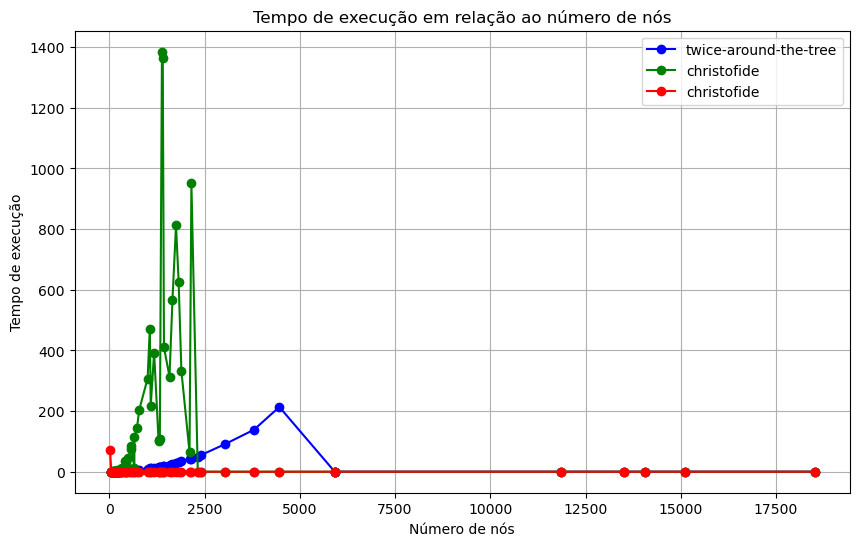

In [ ]:
# Plotar gráfico
plt.figure(figsize=(10, 6))

plt.plot(df_atat['Nós'], df_atat['tempo execução'], marker='o', color='blue', label='twice-around-the-tree')
plt.plot(df_achr['Nós'], df_achr['tempo execução'], marker='o', color='green', label='christofide')
plt.plot(df_bb['Nós'], df_bb['tempo execução'], marker='o', color='red', label='christofide')

plt.title("Tempo de execução em relação ao número de nós")
plt.xlabel("Número de nós")
plt.ylabel("Tempo de execução")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
file_paths = [
    'dados/analise_branch-and-bound.txt',
    'dados/analise_twice-around-the-tree.txt',
    'dados/analise_christofides.txt'
]

# Reading data
columns = ["Dataset", "Nós", "Limiar", "Algoritmo", "Tempo de Execução", "Taxa Aproximação Atingida", "Custo Caminho Atingido", "Espaço (MB) Usado", "CPU (%)", "RAM (%)", "Disco (%)"]
dataframes = [pd.read_csv(file, sep="\t", header=0, names=columns, engine='python') for file in file_paths]

# Merging datasets
data = pd.concat(dataframes, ignore_index=True)

# Cleaning and converting data
data = data.dropna(subset=["Nós", "Taxa Aproximação Atingida", "Custo Caminho Atingido", "Espaço (MB) Usado", "CPU (%)", "RAM (%)", "Disco (%)"])
for col in ["Nós", "Taxa Aproximação Atingida", "Custo Caminho Atingido", "Espaço (MB) Usado", "CPU (%)", "RAM (%)", "Disco (%)"]:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Create output directory
output_dir = "graficos"
os.makedirs(output_dir, exist_ok=True)

# Plotting function
def plot_metric(data, metric, title):
    plt.figure(figsize=(10, 6))
    for algo in data['Algoritmo'].unique():
        subset = data[data['Algoritmo'] == algo]
        plt.plot(subset['Nós'], subset[metric], label=algo)
    plt.xlabel('Nós')
    plt.ylabel(metric)
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Save the plot
    file_name = os.path.join(output_dir, f"{title.replace(' ', '_')}.png")
    plt.savefig(file_name)
    plt.close()

# Metrics to plot
metrics = ["Taxa Aproximação Atingida", "Custo Caminho Atingido", "Espaço (MB) Usado", "CPU (%)", "RAM (%)", "Disco (%)"]

# Generate plots
for metric in metrics:
    plot_metric(data, metric, f'Gráfico de {metric} por Nós')